In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.neighbors import KNeighborsClassifier
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from pathlib import Path
from scipy.io import loadmat
from datetime import datetime
import torch
import seaborn as sns
import os
import shutil

In [2]:
filtered_files = '8835-8844,8865,886,892,893,8589-8598,8700,8724,8729,894,896,907,909,8614,8644,8690,8679,1234-1240,1257-1264,\
1274,1254,1256,1272,1273,1701-1708,1706,1707'
c1 = '1-48,102-242,653-673,690-711,1709-2018,2364-3308,6534-6713,6884-7038,7784-7888,961-1046,1411-1455'
c2 = '49-101,243-263,314-381,452-500,2019-2363,3309-3508,3864-4408,4944-5333,917-960,1456-1500,7889-8018'
c3 = '289-313,3674-3863'
c4 = '264-288,382-424,526-566,3509-3673,4409-4768,5504-5873'
c5 = '425-451,567-588,4769-4943,5874-6053'
c6 = '501-525,5334-5503'
c7 = '589-628,6054-6368'
c8 = '629-652,802-822,6369-6533,8019-8208'
c9 = '674-689,6714-6883'
c10 = '712-738,861-885,1363-1410,7039-7213,7484-7598,8394-8568'
c11 = '739-759,1317-1362,7214-7483'
c12 = '760-778,8744-8834,8845-8983'
c13 = '779-801,7599-7783'
c14 = '823-838,8209-8393'
c15 = '839-860,8984-9208'  # 有待剔除的2个异常
c16 = '887-891,895,897-906,908,910-914,916,8569-8588,8599-8613,8619,8624-8643,8645-8670,8680-8689,8695,8705-8723,8734-8743'
c17 = '1047-1142'
c18 = '1143-1190'
c19 = '1191-1233,1241-1253,1255,1265-1271,1275-1316'
c20 = '1501-1700'  # 需要重新指定采样频率 or 单独处理  232s的采样频率后，长度为8938
# 标准长度：8928
freqs = ['5min']*19 + ['232s']
classes_str = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20]

In [3]:
# 字符串分割函数，提取每一类的文件号, int类型
def str2class(class_str):
    file_segments = class_str.split(',')
    class_files = []
    for segment in file_segments:
        if '-' in segment:
            befor, after = segment.split('-')
            list_segment = np.arange(int(befor), int(after)+1).tolist()
            class_files.extend(list_segment)
        else:
            class_files.append(int(segment))
    return class_files

# 重采样和长度统一函数
def resample_uniform(file_no, labels, low_bound=8000, length=8928, freq='5min', origin_data=r'D:\Jupyter\AD\datasets-ad\battery\data', channel_first=True):
    '''
    input: 文件号
    output: 统一长度之后的时间序列,shape=[length, channels], np.ndarray
    函数作用: 读取文件，重采样，统一长度并返回重采样的序列和对应的标签
    '''
    file_path = Path(origin_data) / f'{file_no}.txt'
    data = pd.read_csv(file_path, sep='\t', header=None)
    timestamps, values = data.iloc[:, 0].values, data.iloc[:, 1:].values
    timestamps = np.vectorize(datetime.fromtimestamp)(timestamps)
    data = pd.DataFrame(values, index=pd.DatetimeIndex(timestamps))
    data = data.resample(freq).mean().ffill().values
    time = data.shape[0]
    if time <= low_bound:
        return None
    else:
        if time < length:
            delta = np.zeros((length-time, data.shape[1]))
            delta[:] = data[0]
            data = np.concatenate([delta, data], axis=0)
        elif time > length:
            data = data[:length, :]
        label = int(labels[file_no-1])
        if channel_first:
            return data.T, label, file_no
        else:
            return data, label, file_no
    
def class_resample(class_str, labels, low_bound=8000, freq='5min', length=8928, channel_first=True):
    '''
    class_str: 记录一类文件的字符串
    函数作用：将字符串内包含的文件重采样到指定长度后，返回一个类的数据和标签，返回shape为[n_samples, c, time]
    '''
    class_files = str2class(class_str)
    class_data = []
    class_labels = []
    file_nos = []
    for f in class_files:
        infos = resample_uniform(f, labels, length=length, freq=freq, channel_first=channel_first, low_bound=low_bound)
        if infos is not None:
            data, label, file_no = infos
            class_data.append(data)
            class_labels.append(label)
            file_nos.append(file_no)
    class_data = np.stack(class_data)
    return class_data, class_labels, file_nos

def normalize(x, mode='dataset'):
    'x.shape = [n, c, t]'
    assert mode in ['dataset', 'series'], 'only support normalize through whole dataset or using zscore to each series'
    if mode == 'dataset':
        mean, var = [], []
        for channel in range(x.shape[1]):
            x_c = x[:, channel]
            mean.append(x_c.mean())
            var.append(x_c.var(ddof=1))
        mean, var = np.array(mean).reshape(-1, 1), np.array(var).reshape(-1, 1)  # [c, 1]
        x_norm = (x  - mean) / (var + 1e-8)**0.5
    else:
        mean = x.mean(axis=-1).reshape(x.shape[0], x.shape[1], 1)
        var = x.var(axis=-1, ddof=1).reshape(x.shape[0], x.shape[1], 1)
        x_norm = (x - mean) / (var + 1e-8) **0.5
    return x_norm

def normalize_save(classes_strs, labels, freqs, length=8928, channel_first=True, save_dir=r'D:\Jupyter\AD\datasets-ad\battery', to_txt=False):
    # class normalize save
    # 一步到位的函数
    '''
    classes_strs: 记录一类中所包含的文件号的字符串列表
    freqs: 记录每个类的采样频率的列表
    函数作用: 创建两个文件夹，一个存储所有数据重采样后和全数据标准化的结果，另一个存储每个类重采样和类内标准化的结果，返回所有样本的个数
    '''
    all_data_dir = Path(save_dir) / f'all_data_resample_{length}'
    class_data_dir = Path(save_dir) / f'class_resample_{length}'
    class_data_dir.mkdir(exist_ok=True)
    all_data_dir.mkdir(exist_ok=True)
    all_data_origin = all_data_dir / 'origin_resample.npy'
    all_data_norm = all_data_dir / 'resample_datasetnorm.npy'
    all_data_labels = all_data_dir / 'all_data_labels.npy'
    all_data = []
    all_labels = []
    for idx, (c, freq) in enumerate(zip(classes_strs, freqs)):
        c_folder = class_data_dir / f'class_{idx+1}'
        c_folder.mkdir(exist_ok=True)
        c_dir = c_folder / 'origin_resample.npy'
        c_norm_dir = c_folder / 'resample_classnorm.npy'
        c_labels_dir = c_folder / 'class_labels.npy'
        c_data, c_labels, file_nos = class_resample(c, labels, freq=freq, length=length, channel_first=channel_first)
        np.save(c_dir, c_data)
        np.save(c_norm_dir, normalize(c_data))
        np.save(c_labels_dir, c_labels)
        all_data.append(c_data)
        all_labels.append(c_labels)
        if to_txt:
            class_txt_dir = c_folder / 'txt'
            class_txt_dir.mkdir(exist_ok=True)
            for idx, d in enumerate(c_data):
                dataframe = pd.DataFrame(d)
                dataframe.to_csv(class_txt_dir/f'{idx+1}.txt', sep='\t')
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    normalized_data = normalize(all_data)
    np.save(all_data_origin, all_data)
    np.save(all_data_norm, normalized_data)
    np.save(all_data_labels, all_labels)
    if to_txt:
        data_txt_dir = all_data_dir / 'norm_txt'
        data_txt_dir.mkdir(exist_ok=True)
        for idx, d in enumerate(normalized_data):
            dataframe = pd.DataFrame(d)
            dataframe.to_csv(data_txt_dir/f'{idx+1}.txt', sep='\t')
    return all_data.shape[0]

def class_plot(class_str, labels, freq='5min', figsize=(10, 4), one_pic=False, save=False, no=1
              , anomaly_scores=None, anomaly_ranks=None):
    '''
    函数作用：给出一个类内文件说明字符串和标签，可以绘制出一个类内序列
    class_str: 说明类内文件的字符串
    labels: 全数据的标签
    freq:采样间隔
    one_pic: 是否绘制在一张图中
    no: 类编号
    '''
    if anomaly_ranks is not None and (not isinstance(anomaly_ranks, list)):
        anomaly_ranks = list(anomaly_ranks)
    class_data, class_labels, file_nos = class_resample(class_str, labels, freq=freq)
    if not one_pic:
        for idx, (d, label,file_no) in enumerate(zip(class_data, class_labels, file_nos)):
            c = 'b'
            if label == 1:
                c = 'r'
            fig, pics = plt.subplots(1, 2, figsize=figsize)
            for i in range(2):
                pics[i].plot(range(1, d.shape[1]+1), d[i], c=c)
                if i == 0:
                    if anomaly_scores is None:
                        pics[i].set_title(f'mean={d[i].mean():.4f}, length={d.shape[1]}, file:{file_no}')
                    else:
                        pics[i].set_title(f'mean={d[i].mean():.4f}, score={anomaly_scores[idx]:.4f}, file:{file_no}')
                else:
                    if anomaly_ranks is None:
                        pics[i].set_title(f'mean={d[i].mean():.4f}')
                    else:
                        pics[i].set_title(f'mean={d[i].mean():.4f}, rank={anomaly_ranks.index(idx+1)+1}')
            plt.tight_layout()
            plt.show()
    else:
        fig, pics = plt.subplots(1, 2, figsize=figsize)
        for d, label in zip(class_data, class_labels):
            c, zorder, alpha = 'b', 1, 0.5
            if label == 1:
                c, zorder, alpha = 'r', 2, 1
            for i in range(2):
                pics[i].plot(range(1, d.shape[1]+1), d[i], c=c, zorder=zorder, alpha=alpha)
                pics[i].tick_params(labelsize=12)
        plt.tight_layout()
        if save:
            save_dir = Path(r'./class_polt')
            save_dir.mkdir(exist_ok=True)
            class_dir = save_dir / f'class_{no}.png'
            plt.savefig(class_dir, dpi=1000)
        plt.show()
    return class_data.shape[0]

In [4]:
def read_origin(file, origin_data=r'D:\Jupyter\AD\datasets-ad\battery\data', channel_first=True, resample=False):
    '''
    file: 文件号
    函数作用: 读取文件，并返回时间轴的采样频率信息以及采样的起始和终止时间
    '''
    file_path = Path(origin_data) / f'{file}.txt'
    data = pd.read_csv(file_path, sep='\t', header=None)
    value, timestamp = data.iloc[:, 1:].values, np.vectorize(datetime.fromtimestamp)(data.iloc[:, 0].values)
    frequency = timestamp[1:] - timestamp[:-1]
    frequency = [i.total_seconds()//60 for i in frequency]
    if channel_first:
        value = value.T
    if not resample:
        return (timestamp[0], timestamp[-1]), (int(min(frequency)), int(max(frequency))), value
    else:
        if channel_first:
            data = pd.DataFrame(value.T, index=pd.DatetimeIndex(timestamp))
        else:
            data = pd.DataFrame(value, index=pd.DatetimeIndex(timestamp))
        return (timestamp[0], timestamp[-1]), (int(min(frequency)), int(max(frequency))), data
    
def resample_save(interval, root=r'D:\Jupyter\AD\datasets-ad\battery', length=2000, local=10):
    data_root = Path(root) / 'data'
    target_root = (Path(root) / 'resample_test')
    target_root.mkdir(exist_ok=True)
    files = sorted([int(f.stem) for f in data_root.iterdir() if f.suffix == '.txt'])
    for i, f in enumerate(files):
        if interval[0] <= int(f.stem) <interval[1]:
            path = data_root / f'{f}.txt'
            d = pd.read_csv(path, sep='\t', header=None).iloc[:, 1:].values
            sampled_d = resample(d, length, local)
            d = pd.DataFrame(sampled_d)
            d.to_csv(target_root / f'{f}.txt')
            
def resample(signal, length, local=10, retmode=False, keep_local_extrem=None):
    keep_local_extrem = int(0.1*length) if keep_local_extrem is None else keep_local_extrem
    signal = np.array(signal)
    n = signal.shape[0]
    if n == length:
        if retmode:
            return (signal, 'hold')
        else:
            return signal
    mode = 'down' if signal.shape[0] > length else 'up'
    if mode == 'down':
        index = np.floor(np.linspace(0, signal.shape[0] - 1, length)).astype(np.int32)
        res = np.take(signal, index, axis=0)
        # 局部极值
        loc_extrem = [(np.abs(point - signal[:, 1][i:i + local].mean()) + np.abs(
            point - signal[:, 1][i + local:i + 2 * local].mean())) / 2
                      for i, point in enumerate(signal[:, 1][local:-local])]
        extrem_ind = np.argsort(np.array(loc_extrem))[-keep_local_extrem:] + local
        ind = np.floor(length * (extrem_ind / signal.shape[0])).astype(np.int32)
        res[ind] = signal[extrem_ind]
    else:
        if signal.ndim == 1:
            shape = length
        else:
            shape = (length, signal.shape[1])
        res = np.full(shape, np.inf)
        pos = np.floor(np.linspace(0, length - 1, n)).astype(np.int32)  # 选出均匀的原信号索引
        ind = 0
        for i in range(length):
            if i in pos:  # 有n个原位置
                res[i] = signal[ind]
                ind += 1
            else:  # length - n 个待填充位置
                res[i] = res[i - 1]
    if retmode:
        return res, mode
    else:
        return res

def read_ts(cols=2, root=r'D:\Jupyter\AD\datasets-ad\battery\resample', normalize=False, channel_first=True, sep='\t'):
    def normalize(x, mode='dataset'):
        # x.shape = [n, c, t]
        assert mode in ['dataset', 'series'], 'only support normalize through whole dataset or using zscore to each series'
        if mode == 'dataset':
            mean, var = [], []
            for channel in range(x.shape[1]):
                x_c = x[:, channel]
                mean.append(x_c.mean())
                var.append(x_c.var(ddof=1))
            mean, var = np.array(mean).reshape(-1, 1), np.array(var).reshape(-1, 1)  # [c, 1]
            x_norm = (x  - mean) / (var + 1e-8)**0.5
        else:
            mean = x.mean(axis=-1).reshape(x.shape[0], x.shape[1], 1)
            var = x.var(axis=-1, ddof=1).reshape(x.shape[0], x.shape[1], 1)
            x_norm = (x - mean) / (var + 1e-8) **0.5
        return x_norm

    root = Path(root)
    assert root.is_dir() and root.exists()
    assert cols in [1, 2]
    data = []
    index = []
    for f in root.iterdir():
        if f.is_file and f.suffix == '.txt' and len(f.stem) < 5:
            use_col = 1 if cols == 2 else 2
            d = pd.read_csv(f, sep=sep).iloc[:, use_col:].values
            d = d if not channel_first else d.T
            data.append(d)
            index.append(int(f.stem))
    zips = [(d, i) for d, i in zip(data, index)]
    zips.sort(key=lambda x:x[1])
    data = np.concatenate([d.reshape(1, d.shape[0], d.shape[1]) for d, _ in zips])
    return normalize(data) if normalize else data

def plot_signal_resample(files, anomaly_files, low_bound=8000, anomaly_scores=None, batch_in_one=False, anomaly_scores_rank=None, resample=True, resample_freq='5min'):
    # files 就是原本的文件号列表, 从1开始
    # specific 是指定的文件号，也是原始文件号
    for f in files:
        c = 'b'
        if f in anomaly_files:
            c = 'r'
        if not resample:
            timestamps, frequencys, signal = read_origin(f, resample=resample)
            time_origin = signal.shape[1]
        else:
            timestamps, frequencys, signal = read_origin(f, resample=resample)
            resample_signal = signal.resample(resample_freq).mean().ffill().values.T
            time_resample = resample_signal.shape[1]
            signal = signal.values.T
            time_origin = signal.shape[1]
            if time_resample < low_bound and c != 'r':
                c = 'green'
        print('='*60+f'file:{f}'+'='*60)
        print(f'Time Span:{timestamps[0]}-{timestamps[1]}')
        print(f'Freq Span:{frequencys[0]}-{frequencys[1]}')
        if not resample:
            fig, pics = plt.subplots(1, 2, figsize=(10, 4))
        else:
            fig, pics = plt.subplots(2, 2, figsize=(10, 4))
        if not resample:
            for i, pic in enumerate(pics):
                pic.plot(range(1, time_origin+1), signal[i], c=c)
                if i == 0:
                    pic.set_xlabel(f'anomaly_score:{anomaly_scores[f-1]}')
                    pic.set_title(f'mean:{signal[i].mean():.4f}, length:{signal.shape[1]}')
                else:
                    pic.set_xlabel(f'anomaly_score_rank:{anomaly_scores_rank.index(f)+1}')
                    pic.set_title(f'mean:{signal[i].mean():.4f}, min:{signal[i].min():.4f}, min_loc:{np.argmin(signal[i])+1}')
        
        else:
            for col in range(2):
                pics[0, col].plot(range(1, time_origin+1), signal[col], c=c)
                if col == 0:
                    pics[0, col].set_xlabel(f'anomaly_score:{anomaly_scores[f-1]}')
                    pics[0, col].set_title(f'mean:{signal[col].mean():.4f}, length:{signal.shape[1]}')
                else:
                    pics[0, col].set_xlabel(f'anomaly_score_rank:{anomaly_scores_rank.index(f)+1}')
                    pics[0, col].set_title(f'mean:{signal[col].mean():.4f}, min:{signal[col].min():.4f}, min_loc:{np.argmin(signal[col])+1}')
            for col in range(2):
                pics[1, col].plot(range(1, time_resample+1), resample_signal[col], c=c)
                if col == 0:
                    pics[1, col].set_title(f'mean:{resample_signal[col].mean():.4f}, length:{resample_signal.shape[1]}')
                else:
                    pics[1, col].set_title(f'mean:{resample_signal[col].mean():.4f}, min:{resample_signal[col].min():.4f}, min_loc:{np.argmin(resample_signal[col])+1}')
                    
        if not batch_in_one:
            plt.tight_layout()
            plt.show()
    if batch_in_one:
        plt.tight_layout()
        plt.show()
    
def tsne_map(x, label, figsize=(6, 6), s=10, specific_files=None, path=None, dpi=2000, fontsize=14):
    # specific_files是真实文件号,表示自己选择的想要看位置的文件
    # x 为 n* features的tabular数据
    # label为 x 对应的标签信息
    pos, neg = x[label==0], x[label==1]
    plt.figure(figsize=figsize)
    plt.scatter(pos[:, 0], pos[:, 1], alpha=0.5, marker='.', c='k', label='normal', s=6)
    plt.scatter(neg[:, 0], neg[:, 1], c='magenta', marker='v', s=s, label='outlier')
    if specific_files is not None:
        files = np.array(specific_files) - 1
        plt.scatter(x[files][:, 0], x[files][:, 1], c='cyan', marker='*', s=s, label='selected')
    plt.legend(loc='upper right', fontsize=fontsize)
    if path is not None:
        if dpi is None:
            plt.savefig(path)
        else:
            plt.savefig(path, dpi=dpi)
    plt.tick_params(labelsize=fontsize+2)
    plt.show()
    
def plot_signal(file_range, data, labels, anomaly_scores, anomaly_ranks):
    for f_idx in file_range:
        fig, pics = plt.subplots(1, 2, figsize=(8, 2))
        c = 'b'
        if labels[f_idx] == 1:
            c = 'r'
        for i in range(2):
            pics[i].plot(range(1, data.shape[2]+1), data[f_idx][i], c=c)
            if i == 0:
                pics[i].set_title(f'anomaly_score:{anomaly_scores[f_idx]:.4f},mean:{data[f_idx][i].mean():.4f}')
            else:
                pics[i].set_title(f'anomaly_rank:{anomaly_ranks.index(f_idx+1)+1},mean:{data[f_idx][i].mean():.4f}')
        plt.tight_layout()
        plt.show()

# 分类/可视化

In [ ]:
# anomaly_scores_inne = np.load('anomaly_scores_inne_crt.npy')
# anomaly_rank_inne = np.load('anomaly_scores_rank_inne_crt.npy').tolist()
infos = loadmat(r'D:\Jupyter\AD\datasets-ad\battery\data.mat')
labels = infos['class'].reshape(-1)
anomaly_files = np.arange(1, 9209)[labels==1]

In [ ]:
plot_signal(str2class(c1), anomaly_files, resample=True, resample_freq='5min', low_bound=4000, 
            anomaly_scores=anomaly_scores_inne, anomaly_scores_rank=anomaly_rank_inne, batch_in_one=False)

In [ ]:
tsne_map(reprs_2d, labels, specific_files=np.arange(8870, 8984))

In [ ]:
plot_signal(str2class(c1), anomaly_files, resample=True, resample_freq='10min', low_bound=4000, 
            anomaly_scores=anomaly_scores_inne, anomaly_scores_rank=anomaly_rank_inne, batch_in_one=False)

In [ ]:
data = pd.read_csv(r'D:\Jupyter\AD\datasets-ad\battery\data\1501.txt', sep='\t', header=None)
timestamps =  np.vectorize(datetime.fromtimestamp)(data.iloc[:, 0].values)
intervals = timestamps[1:] - timestamps[:-1]
min_i = 10
max_i = -1
max_befor, max_after = None, None
min_befor, min_after = None, None
for idx, i in enumerate(intervals):
    print(i.total_seconds()//60)
    if i.total_seconds()//60 > max_i:
        max_i = i.total_seconds()//60
        max_befor = timestamps[idx]
        max_after = timestamps[idx+1]
    elif i.total_seconds()//60 < min_i:
        min_i = i.total_seconds()//60
        min_befor = timestamps[idx]
        min_after = timestamps[idx+1]
print(f'max_interval:{max_i}, befor:{max_befor}, after:{max_after}')
print(f'min_interval:{min_i}, befor:{min_befor}, after:{min_after}')

In [ ]:
for t in timestamps:
    print(t)

# 保存/可视化分析

In [ ]:
normalize_save(classes_str, labels, freqs, to_txt=False)

In [ ]:
# 各类中包含序列的个数
# 以及去除了39个异常
# 总共可用样本数量：3161
# 0是方便的，从索引1开始是第一类的序列数量
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
class_index = np.cumsum(num_of_series)

In [ ]:
# class 1
class1_num = class_plot(c1, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=1)
print(class1_num)

In [ ]:
# class 2
class2_num = class_plot(c2, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=2)
print(class2_num)

In [ ]:
# class 3
class3_num = class_plot(c3, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=3)
print(class3_num)

In [ ]:
# class 4
class4_num = class_plot(c4, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=4)
print(class4_num)

In [ ]:
# class 5
class5_num = class_plot(c5, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=5)
print(class5_num)

In [ ]:
# class 6
class6_num = class_plot(c6, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=6)
print(class6_num)

In [ ]:
# class 7
class7_num = class_plot(c7, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=7)
print(class7_num)

In [ ]:
# class 8
class8_num = class_plot(c8, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=8)
print(class8_num)

In [ ]:
# class 9
class9_num = class_plot(c9, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=9)
print(class9_num)

In [ ]:
# class 10
class10_num = class_plot(c10, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=10)
print(class10_num)

In [ ]:
# class 11
class11_num = class_plot(c11, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=11)
print(class11_num)

In [ ]:
# class 12
class12_num = class_plot(c12, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=12)
print(class12_num)

In [ ]:
# class 13
class13_num = class_plot(c13, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=13)
print(class13_num)

In [ ]:
# class 14
class14_num = class_plot(c14, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=14)
print(class14_num)

In [ ]:
# class 15
class15_num = class_plot(c15, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=15)
print(class15_num)

In [ ]:
# class 16
class16_num = class_plot(c16, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=16)
print(class16_num)

In [ ]:
# class 17
class17_num = class_plot(c17, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=17)
print(class17_num)

In [ ]:
# class 18
class18_num = class_plot(c18, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=18)
print(class18_num)

In [ ]:
# class 19
class19_num = class_plot(c19, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=19)
print(class19_num)

In [ ]:
# class 20
class20_num = class_plot(c20, labels, freq='232s', figsize=(10, 2), one_pic=True, save=True, no=20)
print(class20_num)

In [ ]:
# outlier
outlier_num = class_plot(filtered_files, labels, freq='5min', figsize=(10, 2), one_pic=True, save=True, no=21)
print(outlier_num)

# 分析清洗后的样本

In [ ]:
all_data_path = r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\resample_datasetnorm.npy'
all_labels_path = r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy'
data = np.load(all_data_path)
labels = np.load(all_labels_path)
anomaly_files = np.arange(1, 3162)[labels==1]

In [ ]:
# 所有样本的顺序是按照类别的顺序排的
class_no = 1
for d, label in zip(data[class_index[class_no-1]:class_index[class_no]], labels[class_index[class_no-1]:class_index[class_no]]):
    fig, pics = plt.subplots(1, 2, figsize=(10, 2))
    c = 'b'
    if label == 1:
        c = 'r'
    for i in range(2):
        pics[i].plot(range(1,data.shape[2]+1), d[i], c=c)
        pics[i].set_title(f'mean={d[i].mean()}')
    plt.tight_layout()
    plt.show()

In [ ]:
# class1
class_no = 20
class_data_path = fr'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_{class_no}\resample_classnorm.npy'
class_labels_path = fr'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_{class_no}\class_labels.npy'
data = np.load(class_data_path)
labels = np.load(class_labels_path)
for d, label in zip(data, labels):
    fig, pics = plt.subplots(1, 2, figsize=(10, 2))
    c = 'b'
    if label == 1:
        c = 'r'
    for i in range(2):
        pics[i].plot(range(1,data.shape[2]+1), d[i], c=c)
        pics[i].set_title(f'mean={d[i].mean()}')
    plt.tight_layout()
    plt.show()

# 异常分分布可视化

In [82]:
method = 'dif'
embedding_method = 'ts2vec'
name = 'global'
dim = '256'
path = Path(fr'anomaly_scores_distribution_{name}')
predict_path = Path(r'./Predict_result')
path.mkdir(exist_ok=True)

In [ ]:
new_labels = []
for i in range(1, 21):
    path = fr'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_{i}\class_labels.npy'
    original_labels = np.load(path)
    n_samples = original_labels.shape[0]
    if i not in [1, 2, 11, 13]:
        c_labels = [0 for k in range(n_samples)]
        new_labels.extend(c_labels)
    else:
        new_labels.extend(original_labels)
new_labels = np.array(new_labels)

In [ ]:
np.save('./new_anomaly_label')

## Class 5

In [83]:
class_no = 5
anomaly_scores_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_{method}_{embedding_method}_class{class_no}_finch.npy'
anomaly_ranks_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_rank_{method}_{embedding_method}_class{class_no}_finch.npy'
reprs_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy'
labels_path = r'./new_anomaly_labels.npy'
class_labels_path = r'./finch_class_labels.npy'
instance_reprs = np.load(reprs_path)
outlier_labels = np.load(labels_path)
class_labels = np.load(class_labels_path)
instance_reprs = instance_reprs[class_labels==class_no]
outlier_labels = outlier_labels[class_labels==class_no]
anomaly_scores = np.load(anomaly_scores_path)
anomaly_scores_rank = np.load(anomaly_ranks_path)

In [56]:
# class_plot(c1, labels, anomaly_scores=anomaly_scores, anomaly_ranks=anomaly_scores_rank)

In [57]:
#anomaly score top 5 series
top_k = 10
top_k_anomaly_scores_index = np.argsort(anomaly_scores)[-top_k:]
top_k_anomaly_scores = anomaly_scores[top_k_anomaly_scores_index]
top_k_anomaly_scores = (top_k_anomaly_scores - top_k_anomaly_scores.min()) / (top_k_anomaly_scores.max()-top_k_anomaly_scores.min())
# top_k_anomaly_scores = (top_k_anomaly_scores - top_k_anomaly_scores.mean()) / top_k_anomaly_scores.std(ddof=1)
real_anomaly_index = np.arange(class_1_labels.shape[0])[class_1_labels==1]
# real anomaly vs top 5 anomaly
fig, pics = plt.subplots(1, 2, figsize=(20, 5))
for col in range(2):
    for i, idx in enumerate(top_k_anomaly_scores_index):
        color = 'r' if idx in real_anomaly_index else 'b'
        pics[col].plot(np.arange(class_1_data.shape[2]), class_1_data[idx][col], c=cm.Reds(top_k_anomaly_scores[i]), alpha=top_k_anomaly_scores[i])
        pics[col].tick_params(labelsize=17)
fig.suptitle(f'Top {top_k} anomaly score batteries predicted by {method} in class{class_no}', size=25)
#添加独立的colorbar
cax, _ = mpl.colorbar.make_axes(pics)
cmap = cm.get_cmap('Reds')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=17)
# 保存图片
plt.savefig(predict_path / f'{method}_class{class_no}_top{top_k}.png', dpi=1000)
plt.show()

NameError: name 'class_1_labels' is not defined

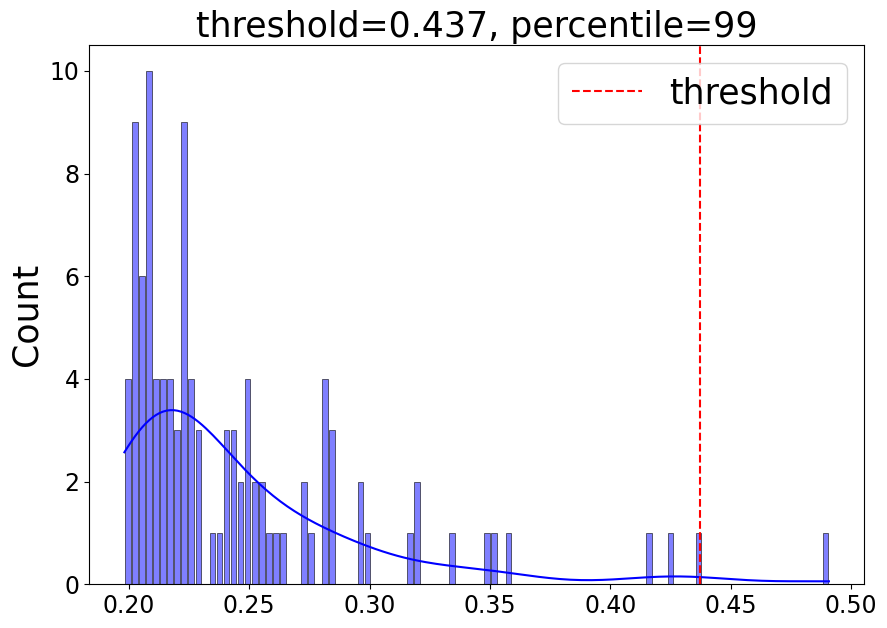

In [84]:
percentile = 99
threshold = np.percentile(anomaly_scores, percentile)
plt.figure(figsize=(10, 7))
sns.histplot(anomaly_scores, kde=True, shrink=0.8, color='blue', bins=100)
plt.ylabel('Count', size=25)
plt.axvline(x=threshold, color='r', linestyle='--', label='threshold')
plt.legend(fontsize=25, loc='upper right')
plt.tick_params(labelsize=17)
plt.title(f'threshold={threshold:.3f}, percentile={percentile}', size=25)
plt.savefig(path/f'class{class_no}_{method}.png', dpi=1000)
plt.show()
# 双中心？

## Class 6

In [85]:
class_no = 5
anomaly_scores_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_{method}_{embedding_method}_class{class_no}_finch.npy'
anomaly_ranks_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_rank_{method}_{embedding_method}_class{class_no}_finch.npy'
reprs_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy'
labels_path = r'./new_anomaly_labels.npy'
class_labels_path = r'./finch_class_labels.npy'
instance_reprs = np.load(reprs_path)
outlier_labels = np.load(labels_path)
class_labels = np.load(class_labels_path)
instance_reprs = instance_reprs[class_labels==class_no]
outlier_labels = outlier_labels[class_labels==class_no]
anomaly_scores = np.load(anomaly_scores_path)
anomaly_scores_rank = np.load(anomaly_ranks_path)

In [73]:
# class_plot(c2, labels, anomaly_scores=anomaly_scores, anomaly_ranks=anomaly_scores_rank)

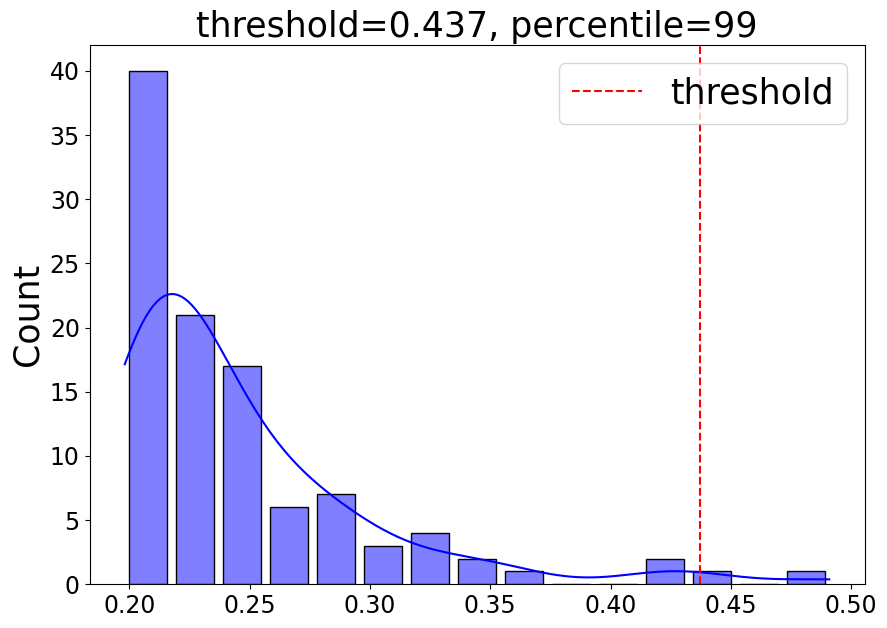

In [86]:
percentile = 99
threshold = np.percentile(anomaly_scores, percentile)
plt.figure(figsize=(10, 7))
sns.histplot(anomaly_scores, kde=True, shrink=0.8, color='blue')
plt.ylabel('Count', size=25)
plt.axvline(x=threshold, color='r', linestyle='--', label='threshold')
plt.legend(fontsize=25, loc='upper right')
plt.tick_params(labelsize=17)
plt.title(f'threshold={threshold:.3f}, percentile={percentile}', size=25)
plt.savefig(path/f'class{class_no}_{method}.png', dpi=1000)
plt.show()
# 双中心？

In [ ]:
#anomaly score top 5 series
top_k = 10
top_k_anomaly_scores_index = np.argsort(anomaly_scores)[-top_k:]
top_k_anomaly_scores = anomaly_scores[top_k_anomaly_scores_index]
top_k_anomaly_scores = (top_k_anomaly_scores - top_k_anomaly_scores.min()) / (top_k_anomaly_scores.max()-top_k_anomaly_scores.min())
# top_k_anomaly_scores = (top_k_anomaly_scores - top_k_anomaly_scores.mean()) / top_k_anomaly_scores.std(ddof=1)
real_anomaly_index = np.arange(class_2_labels.shape[0])[class_2_labels==1]
# real anomaly vs top 5 anomaly
fig, pics = plt.subplots(1, 2, figsize=(20, 5))
for col in range(2):
    for i, idx in enumerate(top_k_anomaly_scores_index):
        color = 'r' if idx in real_anomaly_index else 'b'
        pics[col].plot(np.arange(class_2_data.shape[2]), class_2_data[idx][col], c=cm.Reds(top_k_anomaly_scores[i]), alpha=top_k_anomaly_scores[i])
        pics[col].tick_params(labelsize=17)
fig.suptitle(f'Top {top_k} anomaly score batteries predicted by {method} in class{class_no}', size=25)
#添加独立的colorbar
cax, _ = mpl.colorbar.make_axes(pics)
cmap = cm.get_cmap('Reds')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=17)
# 保存图片
plt.savefig(predict_path / f'{method}_class{class_no}_top{top_k}.png', dpi=1000)
plt.show()

## Class 13

In [87]:
class_no = 13
anomaly_scores_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_{method}_{embedding_method}_class{class_no}_finch.npy'
anomaly_ranks_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_rank_{method}_{embedding_method}_class{class_no}_finch.npy'
reprs_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy'
labels_path = r'./new_anomaly_labels.npy'
class_labels_path = r'./finch_class_labels.npy'
instance_reprs = np.load(reprs_path)
outlier_labels = np.load(labels_path)
class_labels = np.load(class_labels_path)
instance_reprs = instance_reprs[class_labels==class_no]
outlier_labels = outlier_labels[class_labels==class_no]
anomaly_scores = np.load(anomaly_scores_path)
anomaly_scores_rank = np.load(anomaly_ranks_path)

In [76]:
# class_plot(c10, labels, anomaly_scores=anomaly_scores, anomaly_ranks=anomaly_scores_rank)

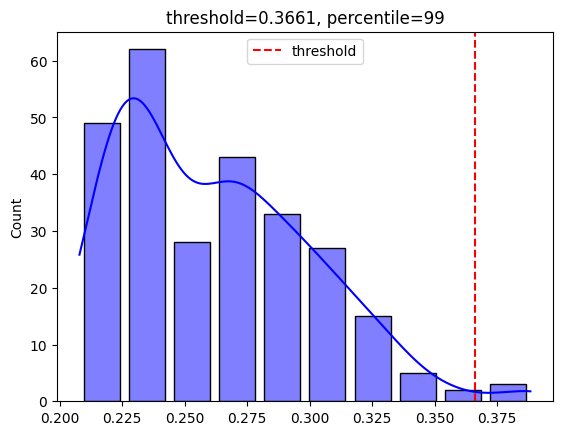

In [88]:
percentile = 99
threshold = np.percentile(anomaly_scores, percentile)
sns.histplot(anomaly_scores, kde=True, shrink=0.8, color='blue')
plt.axvline(x=threshold, color='r', linestyle='--', label='threshold')
plt.legend()
plt.title(f'threshold={threshold:.4f}, percentile={percentile}')
plt.savefig(path/f'class{class_no}_{method}.png', dpi=600)
plt.show()
# 根据1c的均值不同呈现多峰？

## Class 16

In [89]:
class_no = 16
anomaly_scores_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_{method}_{embedding_method}_class{class_no}_finch.npy'
anomaly_ranks_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_rank_{method}_{embedding_method}_class{class_no}_finch.npy'
reprs_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy'
labels_path = r'./new_anomaly_labels.npy'
class_labels_path = r'./finch_class_labels.npy'
instance_reprs = np.load(reprs_path)
outlier_labels = np.load(labels_path)
class_labels = np.load(class_labels_path)
instance_reprs = instance_reprs[class_labels==class_no]
outlier_labels = outlier_labels[class_labels==class_no]
anomaly_scores = np.load(anomaly_scores_path)
anomaly_scores_rank = np.load(anomaly_ranks_path)

In [79]:
# class_plot(c11, labels, anomaly_scores=anomaly_scores, anomaly_ranks=anomaly_scores_rank)

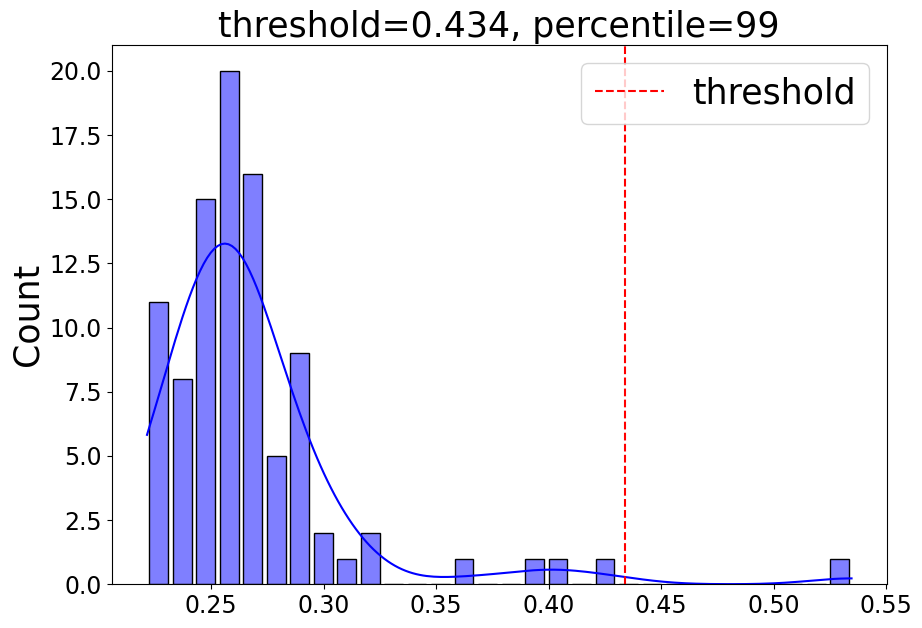

In [90]:
percentile = 99
threshold = np.percentile(anomaly_scores, percentile)
plt.figure(figsize=(10, 7))
sns.histplot(anomaly_scores, kde=True, shrink=0.8, color='blue', bins=30)
plt.ylabel('Count', size=25)
plt.axvline(x=threshold, color='r', linestyle='--', label='threshold')
plt.legend(fontsize=25, loc='upper right')
plt.tick_params(labelsize=17)
plt.title(f'threshold={threshold:.3f}, percentile={percentile}', size=25)
plt.savefig(path/f'class{class_no}_{method}.png', dpi=1000)
plt.show()
# 双中心？

In [ ]:
#anomaly score top 5 series
top_k = 10
top_k_anomaly_scores_index = np.argsort(anomaly_scores)[-top_k:]
top_k_anomaly_scores = anomaly_scores[top_k_anomaly_scores_index]
top_k_anomaly_scores = (top_k_anomaly_scores - top_k_anomaly_scores.min()) / (top_k_anomaly_scores.max()-top_k_anomaly_scores.min())
# top_k_anomaly_scores = (top_k_anomaly_scores - top_k_anomaly_scores.mean()) / top_k_anomaly_scores.std(ddof=1)
real_anomaly_index = np.arange(class_11_labels.shape[0])[class_11_labels==1]
# real anomaly vs top 5 anomaly
fig, pics = plt.subplots(1, 2, figsize=(20, 5))
for col in range(2):
    for i, idx in enumerate(top_k_anomaly_scores_index):
        color = 'r' if idx in real_anomaly_index else 'b'
        pics[col].plot(np.arange(class_11_data.shape[2]), class_11_data[idx][col], c=cm.Reds(top_k_anomaly_scores[i]), alpha=top_k_anomaly_scores[i])
        pics[col].tick_params(labelsize=17)
fig.suptitle(f'Top {top_k} anomaly score batteries predicted by {method} in class{class_no}', size=25)
#添加独立的colorbar
cax, _ = mpl.colorbar.make_axes(pics)
cmap = cm.get_cmap('Reds')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=17)
# 保存图片
plt.savefig(predict_path / f'{method}_class{class_no}_top{top_k}.png', dpi=1000)
plt.show()

# 全局异常分融合

# without 10-12-14

In [91]:
classes = [5, 6, 13, 16]  # 10, 12, 14
scores_path = Path(fr'./global2class_{embedding_method}_{dim}_{name}')
class_labels_path = r'./finch_class_labels.npy'
outlier_labels_path = Path(r'./new_anomaly_labels.npy')
class_labels = np.load(class_labels_path)
outlier_labels = np.load(labels_path)
all_anomaly_scores = []
all_labels = []
for c in classes:
    c_path = scores_path / f'anomaly_scores_{method}_{embedding_method}_class{c}_finch.npy'
    anomaly_scores_c = np.load(c_path)
    anomaly_scores_c = (anomaly_scores_c - anomaly_scores_c.min()) / (anomaly_scores_c.max() - anomaly_scores_c.min())
    c_labels = outlier_labels[class_labels==c]
    all_anomaly_scores.append(anomaly_scores_c)
    all_labels.append(c_labels)
all_anomaly_scores = np.concatenate(all_anomaly_scores, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
x_roc, y_roc, _ = roc_curve(all_labels, all_anomaly_scores, pos_label=1)
y_prc, x_prc, _ = precision_recall_curve(all_labels, all_anomaly_scores, pos_label=1)
auc_roc = auc(x_roc, y_roc)
auc_pr = auc(x_prc[::-1], y_prc[::-1])
print(f'AUC-ROC:{auc_roc}, AUC-PR:{auc_pr}')

AUC-ROC:0.984072375127421, AUC-PR:0.5530444566467857


In [ ]:
'LOF': AUC-ROC:0.9951580020387361, AUC-PR:0.7839795008912656
'INNE': AUC-ROC:0.9982161060142712, AUC-PR:0.862665343915344
'COF': AUC-ROC:0.9811416921508664, AUC-PR:0.7576676676676677
'EIF': AUC-ROC:0.9125891946992865, AUC-PR:0.28408186304981636
'IF' : AUC-ROC:0.9873853211009174, AUC-PR:0.5624559082892416
'KNN': AUC-ROC:0.9557849133537207, AUC-PR:0.6175807573583758
'DIF' : AUC-ROC:0.984072375127421, AUC-PR:0.5530444566467857

In [ ]:
np.save(fr'{embedding_method}_{name}_without10-12-14_global_anomaly_score_{method}.npy', all_anomaly_scores)
np.save(fr'{embedding_method}_{name}_without10-12-14_auc_score_{method}.npy', np.array([auc_roc, auc_pr]))

In [ ]:
percentile = 99
threshold = np.percentile(all_anomaly_scores, percentile)
plt.figure(figsize=(10, 7))
sns.histplot(all_anomaly_scores, kde=True, shrink=0.8, color='blue')
plt.tick_params(labelsize=17)
plt.ylabel('Count', size=25)
plt.axvline(x=threshold, color='r', linestyle='--', label='threshold')
plt.legend(fontsize=25, loc='upper right')
plt.title(f'threshold={threshold:.2f}, percentile={percentile}', size=25)
plt.savefig(path/f'all_data_without10-12-14_mix_{method}_ROC_{auc_roc:.4f}_PR_{auc_pr:.4f}.png', dpi=1000)
plt.show()

# without 10-12

In [ ]:
classes = [1, 2, 11, 13, 14]  # 10, 12, 14
scores_path = Path(fr'./global2class_ts2vec_256_{name}')
labels_path = Path(r'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928')
all_anomaly_scores = []
all_labels = []
for c in classes:
    c_path = scores_path / f'anomaly_scores_{method}_{embedding_method}_class{c}.npy'
    anomaly_scores_c = np.load(c_path)
    anomaly_scores_c = (anomaly_scores_c - anomaly_scores_c.min()) / (anomaly_scores_c.max() - anomaly_scores_c.min())
    c_labels_path = labels_path / fr'class_{c}/class_labels.npy'
    c_labels = np.load(c_labels_path)
    all_anomaly_scores.append(anomaly_scores_c)
    all_labels.append(c_labels)
all_anomaly_scores = np.concatenate(all_anomaly_scores, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
x_roc, y_roc, _ = roc_curve(all_labels, all_anomaly_scores, pos_label=1)
y_prc, x_prc, _ = precision_recall_curve(all_labels, all_anomaly_scores, pos_label=1)
auc_roc = auc(x_roc, y_roc)
auc_pr = auc(x_prc[::-1], y_prc[::-1])
print(f'AUC-ROC:{auc_roc}, AUC-PR:{auc_pr}')

In [ ]:
np.save(fr'without10-12_global_anomaly_score_{method}.npy', all_anomaly_scores)
np.save(fr'without10-12_auc_score_{method}.npy', np.array([auc_roc, auc_pr]))

In [ ]:
percentile = 99
threshold = np.percentile(all_anomaly_scores, percentile)
sns.histplot(all_anomaly_scores, kde=True, shrink=0.8, color='blue')
plt.axvline(x=threshold, color='r', linestyle='--', label='threshold')
plt.legend()
plt.title(f'threshold={threshold:.4f}, percentile={percentile}')
plt.savefig(path/f'all_data_without10-12_mix_{method}_ROC_{auc_roc:.4f}_PR_{auc_pr:.4f}.png', dpi=600)
plt.show()

# 保存特征和模型

In [ ]:
date = 425
feature_root = Path(r'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928')
model_root = Path(r'D:\Jupyter\TS Projects\RT\class_model')
tgt = Path(fr'C:/Users/84396/Desktop/features/{date}')
tgt.mkdir(exist_ok=True)
model_dir = tgt / 'model'
feature_dir = tgt / 'feature'
feature_dir.mkdir(exist_ok=True)
for c in range(1, 21):
    feature_c = feature_root / f'class_{c}' / 'rt_class_features_256_4.npy'
    tgt_c = feature_dir / f'rt_class{c}_features_256_4.npy'
    shutil.copy(feature_c, tgt_c)
shutil.copytree(model_root, model_dir)

# 用KNN分类器（cosine距离）

In [ ]:
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
num_of_series= np.cumsum(num_of_series)
reprs = np.load(fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_{name}.npy')
# 区分出每个类别
class_reprs = [reprs[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]
class_labels = [np.full(each.shape[0], idx+1) for idx, each in enumerate(class_reprs)]
all_labels = np.concatenate(class_labels, axis=0)


# 划分训练集和测试集
num_test = 10
training_set = [reprs[num_of_series[i]:num_of_series[i+1]][:-num_test] for i in range(len(num_of_series)-1)]
training_set = np.concatenate(training_set, axis=0)
training_labels = [all_labels[num_of_series[i]:num_of_series[i+1]][:-num_test] for i in range(len(num_of_series)-1)]
training_labels = np.concatenate(training_labels, axis=0)
test_set = [reprs[num_of_series[i]:num_of_series[i+1]][-num_test:] for i in range(len(num_of_series)-1)]
test_set = np.concatenate(test_set, axis=0)
test_labels = [all_labels[num_of_series[i]:num_of_series[i+1]][-num_test:] for i in range(len(num_of_series)-1)]
test_labels = np.concatenate(test_labels, axis=0)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
clf.fit(training_set, training_labels)

In [ ]:
result = clf.predict(test_set)
acc = np.sum(result==test_labels) / test_labels.shape[0]
print(acc)

# SVM分类器

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
clf_svm = SVC(cache_size=4096)
param_grid_svm = {'C':[0.1, 0.5, 1, 10, 100, 1000], 'kernel':['linear', 'poly', 'rbf'], 'degree':np.arange(2, 5), 'gamma':['scale','auto']+list(np.linspace(0.001, 1, 10))}
clf_svm = GridSearchCV(clf_svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=10)
clf_svm.fit(training_set, training_labels)

In [ ]:
clf_svm.best_score_, clf_svm.best_params_

In [ ]:
result = clf.predict(test_set)
acc = np.sum(result==test_labels) / test_labels.shape[0]
print(acc)

# 线性回归

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf_lr = LogisticRegression(penalty='l2', class_weight='balanced')
param_grid_lr = {'C':[1, 0.1, 0.5, 10, 100, 1000], 'solver':['liblinear', 'saga']}
clf_lr = GridSearchCV(clf_lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=10)
clf_lr.fit(training_set, training_labels)

In [ ]:
clf_lr.best_score_, clf_lr.best_params_

In [ ]:
result = clf.predict(test_set)
acc = np.sum(result==test_labels) / test_labels.shape[0]
print(acc)

# 随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf_rf = RandomForestClassifier(class_weight='balanced_subsample')
param_grid_rf = {'n_estimators':[100, 200, 300], 'criterion':['gini', 'entropy'], 'max_depth':np.arange(4, 10), 'max_features':['sqrt','log2'], 'max_samples':[0.2, 0.4, 0.6, 0.8]}
clf_rf = GridSearchCV(clf_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
clf_rf.fit(training_set, training_labels)

In [ ]:
clf_rf.best_score_, clf_rf.best_params_

In [ ]:
result = clf.predict(test_set)
acc = np.sum(result==test_labels) / test_labels.shape[0]
print(acc)

## 保存knn模型

In [ ]:
joblib.dump(clf, path / fr'ts2vec_256_reprs_{name}_knn_clf.m')

# 热力图可视化

In [ ]:
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
num_of_series= np.cumsum(num_of_series)
reprs = np.load(r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy')
labels = np.load(r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy')
# 区分出每个类别
class_reprs = [reprs[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]
class_labels = [labels[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]

In [ ]:
# 样本+特征选择
class_no = 13
c_reprs, c_labels = class_reprs[class_no-1], class_labels[class_no-1]
vis_path = Path('./visualize/heatmap')
vis_path.mkdir(exist_ok=True)
select_normal = 50
normal_reprs = c_reprs[c_labels==0]
outlier = c_reprs[c_labels==1]
vis_reprs = np.concatenate([normal_reprs[:select_normal], np.ones((1, c_reprs.shape[1])),outlier], axis=0)
select_feature_nums = 100
variances = np.var(vis_reprs, axis=0, ddof=1)
select_features = np.argsort(variances)[-select_feature_nums:]
vis_reprs = vis_reprs[:,select_features]
# 可视化部分
plt.figure(figsize=(10, 8))
plt.imshow(vis_reprs)
plt.title(f'outliers:{outlier.shape[0]}', fontsize=20)
plt.xlabel('Representation dimensions', fontsize=20)
plt.ylabel('Samples', fontsize=20)
plt.savefig(vis_path / f'class_{class_no}.png', dpi=1000)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
c_reprs, c_labels = class_reprs[class_no-1], class_labels[class_no-1]
tsne_path = Path('./visualize/tsne_map')
tsne_path.mkdir(exist_ok=True)
tsne_reprs = TSNE(n_jobs=12, perplexity=50, n_iter=1500).fit_transform(c_reprs)
tsne_map(tsne_reprs, c_labels, path=tsne_path / f'class_{class_no}.png', fontsize=14)

In [ ]:
# PCA
c_reprs, c_labels = class_reprs[class_no-1], class_labels[class_no-1]
tsne_path = Path('./visualize/pca_map')
tsne_path.mkdir(exist_ok=True)
pca_reprs = PCA().fit_transform(c_reprs)
tsne_map(pca_reprs, c_labels, path=tsne_path / f'class_{class_no}.png', fontsize=14)

# 全数据TSNE分类图

In [ ]:
name = 'global'
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
num_of_series = np.cumsum(num_of_series)
reprs = np.load(fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_{name}.npy')
reprs_2d = TSNE(perplexity=21, metric='cosine', n_iter=2000, init='pca').fit_transform(reprs)
# 区分出每个类别
class_reprs = [reprs_2d[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]
class_labels = [np.full(each.shape[0], idx+1) for idx, each in enumerate(class_reprs)]

In [ ]:
# 子图拼接
class_1_series = np.load(r'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_1\origin_resample.npy')
class_1_labels = np.load(r'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_1\class_labels.npy')
class_1_anomalies = class_1_series[class_1_labels==1]
class_1_normal = class_1_series[class_1_labels==0]
conbine = np.stack([class_1_anomalies[0], class_1_normal[0]])
plt.figure(figsize=(20, 10))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1)
ax1.plot(np.arange(1, conbine.shape[2]+1), conbine[0][0], c='r', label='outlier series')
ax1.plot(np.arange(1, conbine.shape[2]+1), conbine[1][0], c='b', label='normal series')
ax1.legend(loc='upper left', fontsize=15)
ax1.tick_params(labelsize=20)
ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1)
ax2.plot(np.arange(1, conbine.shape[2]+1), conbine[0][1], c='r', label='outlier series')
ax2.plot(np.arange(1, conbine.shape[2]+1), conbine[1][1], c='b', label='normal series')
ax2.tick_params(labelsize=20)
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1)
ax3.plot(np.arange(1000, 4000), conbine[0][1][1000:4000], c='r', label='outlier series')
ax3.plot(np.arange(1000, 4000), conbine[1][1][1000:4000], c='b', label='normal series')
ax3.tick_params(labelsize=20)
ax4 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=3)
for i in range(len(class_reprs)):
    reprs_i = class_reprs[i]
    labels_i = (i+1)
    ax4.scatter(reprs_i[:, 0], reprs_i[:, 1], s=3)
ax4.tick_params(labelsize=20)
plt.savefig(f'./visualize/introduction.png', dpi=1000)
plt.show()

In [ ]:
# 子图拼接
class_1_series = np.load(r'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_1\origin_resample.npy')
class_1_labels = np.load(r'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_1\class_labels.npy')
class_1_anomalies = class_1_series[class_1_labels==1]
class_1_normal = class_1_series[class_1_labels==0]
conbine = np.stack([class_1_anomalies[0], class_1_normal[0]])
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=1)
ax1.plot(np.arange(1, conbine.shape[2]+1), conbine[0][0], c='r', label='outlier series')
ax1.plot(np.arange(1, conbine.shape[2]+1), conbine[1][0], c='b', label='normal series')
ax1.legend(loc='upper left', fontsize=15)
ax1.tick_params(labelsize=20)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1, rowspan=1)
ax2.plot(np.arange(1, conbine.shape[2]+1), conbine[0][1], c='r', label='outlier series')
ax2.plot(np.arange(1, conbine.shape[2]+1), conbine[1][1], c='b', label='normal series')
ax2.tick_params(labelsize=20)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=1, rowspan=1)
ax3.plot(np.arange(1000, 4000), conbine[0][1][1000:4000], c='r', label='outlier series')
ax3.plot(np.arange(1000, 4000), conbine[1][1][1000:4000], c='b', label='normal series')
ax3.tick_params(labelsize=20)
plt.savefig(f'./visualize/introduction_1.png', dpi=1000)
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
for i in range(len(class_reprs)):
    reprs_i = class_reprs[i]
    labels_i = (i+1)
    ax1.scatter(reprs_i[:, 0], reprs_i[:, 1], s=3)
ax1.tick_params(labelsize=20)
plt.savefig(f'./visualize/introduction_2.png', dpi=1000)
plt.show()

# 全数据异常检测

In [ ]:
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
num_of_series= np.cumsum(num_of_series)
reprs = np.load(r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy')
labels = np.load(r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy')
# 区分出每个类别
class_reprs = [reprs[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]
class_labels = [labels[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]

In [ ]:
new_labels = []
for i in range(len(class_labels)):
    if (i+1) in [1, 2, 11, 13]:
        new_labels.append(class_labels[i])
    else:
        new_labels.append(np.zeros(class_labels[i].shape[0]))
new_labels = np.concatenate(new_labels, axis=0)

# 多类组图

In [ ]:
embedding_method = 'ts2vec'
dim = 256
name = 'global'
method = 'lof'

In [ ]:
class_no = 13
anomaly_scores_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_{method}_{embedding_method}_class{class_no}.npy'
anomaly_ranks_path = fr'./global2class_{embedding_method}_{dim}_{name}/anomaly_scores_rank_{method}_{embedding_method}_class{class_no}.npy'
class_13_labels = np.load(fr'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_{class_no}\class_labels.npy')
class_13_data = np.load(fr'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_{class_no}\origin_resample.npy')
anomaly_scores = np.load(anomaly_scores_path)
anomaly_scores_rank = np.load(anomaly_ranks_path)

top_k = 10
top_k_anomaly_scores_index = np.argsort(anomaly_scores)[-top_k:]
top_k_anomaly_scores = anomaly_scores[top_k_anomaly_scores_index]
top_k_anomaly_scores = (top_k_anomaly_scores - top_k_anomaly_scores.min()) / (top_k_anomaly_scores.max()-top_k_anomaly_scores.min())
# top_k_anomaly_scores = (top_k_anomaly_scores - top_k_anomaly_scores.mean()) / top_k_anomaly_scores.std(ddof=1)
real_anomaly_index = np.arange(class_13_labels.shape[0])[class_13_labels==1]
# real anomaly vs top 5 anomaly
fig, pics = plt.subplots(1, 2, figsize=(20, 6))
for col in range(2):
    for i, idx in enumerate(top_k_anomaly_scores_index):
        color = 'r' if idx in real_anomaly_index else 'b'
        pics[col].plot(np.arange(class_13_data.shape[2]), class_13_data[idx][col], c=cm.Reds(top_k_anomaly_scores[i]), alpha=top_k_anomaly_scores[i])
        pics[col].tick_params(labelsize=17)
fig.suptitle(f'Top {top_k} anomaly score batteries predicted by {method} in class{class_no}', size=25)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap='Reds')
ax = plt.axes([0.3, 0.3, 0.08, 0.2])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=top_k_anomaly_scores)
plt.show()